In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [2]:
seen_df = pd.read_csv('data/0_labelled_documents.csv')
seen_df = seen_df[pd.notna(seen_df['INCLUDE'])]
seen_df["seen"] = 1
unseen_df = pd.read_csv('data/0_unlabelled_documents.csv')
df = (pd.concat([seen_df,unseen_df])
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index

print(df.shape)
df.head()

(531167, 108)


,id,title,content,0 - relevant,10 - 3. Quantitative,10 - 4. Qualitative,11 - countries,12 - policy name,2 - 0. Mitigation,2 - 1. Adaptation,...,8 - 15. Cross-sectoral,9 - 0. Ex-post,9 - 1. Ex-ante,9 - 2. Ex-ante (IAM),INCLUDE,random,seen,wosarticle__de,wosarticle__wc,relevant
0,644593,Integral projection models for finite populati...,Continuous types of population structure occur...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,demographic stochasticity; diffusion approxima...,['Ecology'],0.0
1,105446,Choosing the best ancient analogue for project...,After the Paleocene-Eocene Thermal Maximum (PE...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Middle-late Eocene; Halite; Fluid inclusion; H...,"['Geosciences, Multidisciplinary']",0.0
2,707531,Sharing a quota on cumulative carbon emissions,Any limit on future global warming is associat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,['Environmental Sciences; Environmental Studie...,0.0
3,1277928,A Wood Biology Agenda to Support Global Vegeta...,Realistic forecasting of forest responses to c...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,['Plant Sciences'],0.0
4,2271961,Cause-and-effect in Mediterranean erosion: The...,The debate in historical geomorphological stud...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,Cappadocia; Turbidites; Lake; Badland; Erosion...,"['Geography, Physical; Geosciences, Multidisci...",0.0


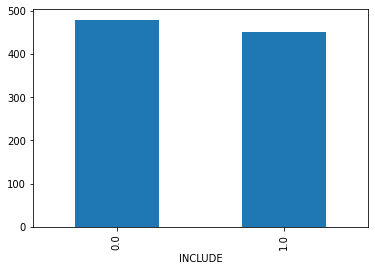

In [3]:
seen_df.groupby('INCLUDE').size().plot.bar()

running vectorisation again


(531167, 3455)

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Here we define the whole pipeline starting from creating features to training a classifier

pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', SVC(probability=True,  class_weight="balanced")),
])

# Now we define the parameter space we want to search. This gets computationally expensive the 
# more parameters we search, as we fit a model for every unique combination of parameters (there are fancier and smarter ways to do this)

parameters = [
    {
        'vect__max_df': (0.3, 0.5, 0.75),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['rbf'], 
        'clf__gamma': [1e-3, 1e-4], # Because only the rbf kernel has the gamma parameters, we do this separately
        'clf__C': [1, 1e1, 1e2, 1e3]
    },
    {
        'vect__max_df': (0.3, 0.5, 0.75),
        'vect__min_df': (5, 10, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [1, 1e1, 1e2, 1e3]
    }
]

clf = GridSearchCV(pipeline, parameters, scoring="f1", n_jobs=8, verbose=1)

In [52]:
# Now we fit them, by default we try a model for each set of parameters for 5 folds of train/test data
# Even with this running in parallel (n_jobs=8) this might be time to get a coffee
clf.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'INCLUDE'])

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  9.9min
[Parallel(n_jobs=8)]: Done 1080 out of 1080 | elapsed: 13.5min finished


GridSearchCV(estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            probability=True))]),
             n_jobs=8,
             param_grid=[{'clf__C': [1, 10.0, 100.0, 1000.0],
                          'clf__gamma': [0.001, 0.0001], 'clf__kernel': ['rbf'],
                          'vect__max_df': (0.3, 0.5, 0.75),
                          'vect__min_df': (5, 10, 15),
                          'vect__ngram_range': ((1, 1), (1, 2))},
                         {'clf__C': [1, 10.0, 100.0, 1000.0],
                          'clf__kernel': ['linear'],
                          'vect__max_df': (0.3, 0.5, 0.75),
                          'vect__min_df': (5, 10, 15),
                          'vect__ngram_range': ((1, 1), (1, 2))}],
             scoring='f1', verbose=1)

In [53]:
# The best model is the combination of parameters with the highest mean score across 5 folds
clf.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.75, min_df=5)),
                ('clf',
                 SVC(C=100.0, class_weight='balanced', gamma=0.001,
                     probability=True))])

In [54]:
# We can also put the results into a dataframe
results = pd.DataFrame(clf.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__C,param_clf__gamma,param_clf__kernel,param_vect__max_df,param_vect__min_df,param_vect__ngram_range,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.568599,0.037242,0.231321,0.026551,1,0.001,rbf,0.3,5,"(1, 1)","{'clf__C': 1, 'clf__gamma': 0.001, 'clf__kerne...",0.652174,0.652174,0.652174,0.652174,0.654545,0.652648,0.000949,127
1,6.448875,0.303230,0.380114,0.022112,1,0.001,rbf,0.3,5,"(1, 2)","{'clf__C': 1, 'clf__gamma': 0.001, 'clf__kerne...",0.652174,0.652174,0.652174,0.652174,0.654545,0.652648,0.000949,127
2,3.601571,0.086559,0.230239,0.024034,1,0.001,rbf,0.3,10,"(1, 1)","{'clf__C': 1, 'clf__gamma': 0.001, 'clf__kerne...",0.652174,0.652174,0.652174,0.652174,0.654545,0.652648,0.000949,127
3,5.437864,0.035498,0.358639,0.032670,1,0.001,rbf,0.3,10,"(1, 2)","{'clf__C': 1, 'clf__gamma': 0.001, 'clf__kerne...",0.652174,0.652174,0.652174,0.652174,0.654545,0.652648,0.000949,127
4,3.444190,0.141937,0.210370,0.017288,1,0.001,rbf,0.3,15,"(1, 1)","{'clf__C': 1, 'clf__gamma': 0.001, 'clf__kerne...",0.652174,0.652174,0.652174,0.652174,0.654545,0.652648,0.000949,127


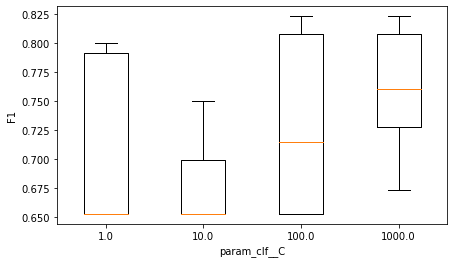

In [71]:
# Now if we want to look at what the individual parameters do we can plot the range of results obtained
# with each value of the parameter
def param_boxes(results, param, scorer="F1"):
    fig, ax = plt.subplots(figsize=(7,4))
    # A list of values for our boxplot
    x = []
    labels = []
    for i, (name, group) in enumerate(results.groupby(param)):
        labels.append(name)
        x.append(group['mean_test_score'])
    ax.boxplot(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel(param)
    ax.set_ylabel(scorer)
    plt.show()
    
param_boxes(results, "param_clf__C")

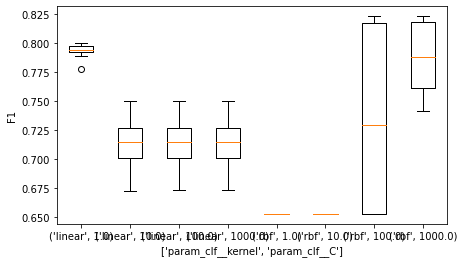

In [72]:
# This also works for a combination of params
param_boxes(results, ["param_clf__kernel","param_clf__C"])

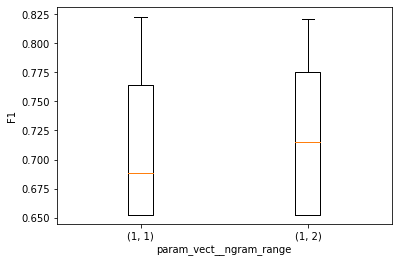

In [62]:
param_boxes(results, "param_vect__ngram_range")

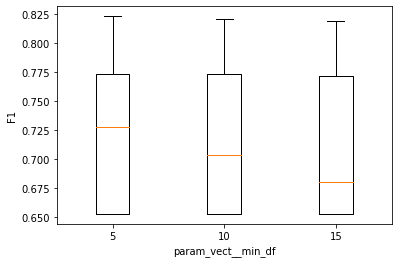

In [63]:
param_boxes(results, "param_vect__min_df")

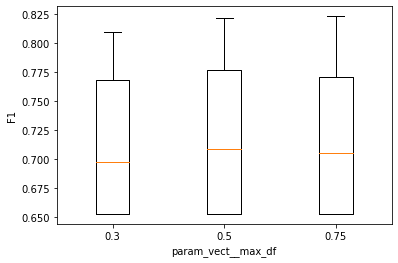

In [64]:
param_boxes(results, "param_vect__max_df")

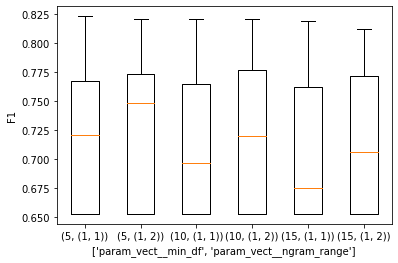

In [59]:
# This also works for a combination of params
param_boxes(["param_vect__min_df","param_vect__ngram_range"])

In [74]:
clf.best_estimator_

Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.75, min_df=5)),
                ('clf',
                 SVC(C=100.0, class_weight='balanced', gamma=0.001,
                     probability=True))])

In [78]:
# We can fit our best model with the whole training set now 
clf.best_estimator_.fit(df.loc[seen_index, 'content'], df.loc[seen_index,'INCLUDE'])
# And obtain predictions for all that we have not yet seen
y_pred = clf.predict_proba(df.loc[unseen_index,'content'])

In [ ]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [5]:
# from sklearn.model_selection import KFold
# from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
# import random


# y = df['INCLUDE']


# from importlib import reload  
# import scoping.utils.learning_utils as lu
# reload(scoping.utils.learning_utils)

# clf_models = [
#     {
#         'title': 'SVM rbf', 
#         'model': SVC(kernel='rbf',class_weight='balanced',probability=True, C=10)
#     },
#     {
#         'title': 'SVM lin C10', 
#         'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=10)
#     },
#     {
#         'title': 'SVM lin C1', 
#         'model': SVC(kernel='linear',class_weight='balanced',probability=True, C=1)
#     },

# ]


# clf_models, df = lu.cross_validate_models(
#     X, y, clf_models, seen_index, n_splits=6, df = df
# )

1
2
3
4
5
6


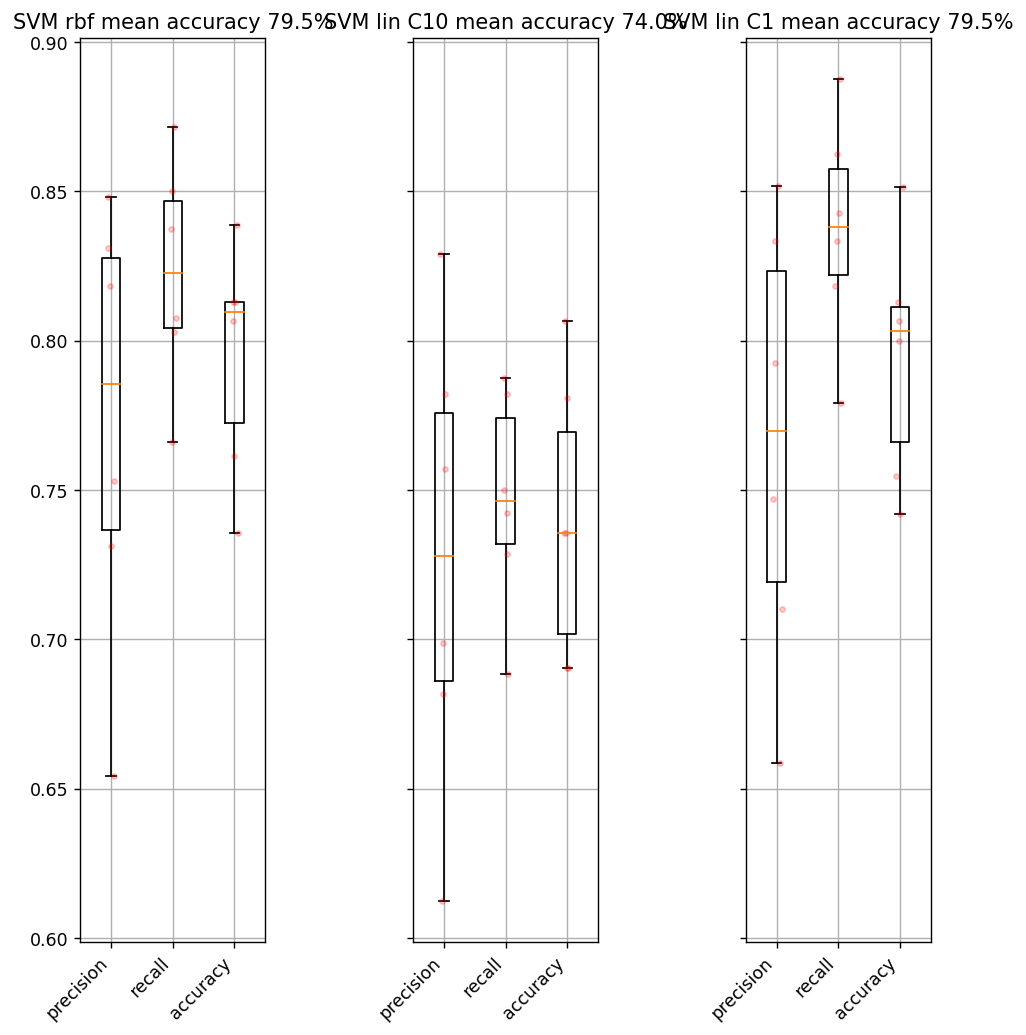

In [16]:
# from importlib import reload  
# import scoping.utils.learning_utils as lu
# reload(scoping.utils.learning_utils)

# fig, axs = plt.subplots(1, len(clf_models),dpi=125,figsize=(8,8),sharey=True)              
# lu.plot_model_output(clf_models,  ['p','r','e'], fig, axs)
# for ax in axs:
#     ax.set_xticklabels(["precision","recall","accuracy"])
# #fig.tight_layout()
# #plt.savefig(f'../plots/prediction_models/relevance_prediction_{now.strftime("%Y-%m-%d_%H:%M:%S")}.pdf',bbox_inches="tight")
# plt.show()

In [17]:
# clf = SVC(kernel='rbf',C=10, class_weight='balanced', probability=True)

# clf.fit(X[seen_index],y[seen_index])

# y_pred = clf.predict_proba(X[unseen_index])

/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/max/software/django-tmv/tmv/venv/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


78884


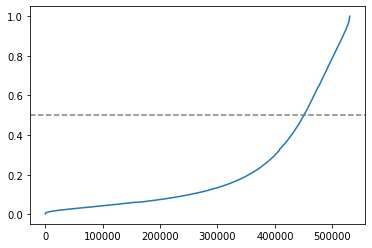

In [18]:
df['prediction'] = None
df['prediction'][unseen_index] = y_pred[:,1]
y_pred.shape

plt.close()

fig, ax = plt.subplots()

pdf = df.sort_values('prediction').reset_index(drop=True)
ax.plot(pdf.index,pdf['prediction'])
ax.axhline(0.5,linestyle="--",color="grey")

print(pdf[pdf['prediction']>0.5].shape[0])

plt.show()

In [20]:
pairs = [
    (['vasudevan@mcc-berlin.net','galm'], 40),      
    (['ceposadap@gmail.com','edmondson@hertie-school.org'], 20),   
    (['lucy.banisch@icloud.com','ceposadap@gmail.com'], 40)
]

new_q = Query.objects.get(pk=8843)

tag, created = Tag.objects.get_or_create(
    title="Probably relevant random sample 10",
    query=new_q,
)

gov_docs = set(df[df['prediction']>=0.5].id)

if created:

    T = Doc.tag.through

    for p in pairs:
        gov_sample = set(random.sample(gov_docs, p[1]))
        gov_docs -= gov_sample

        for did in gov_sample:
            for u in p[0]:
                user = User.objects.get(username=u)
                do, created = DocOwnership.objects.get_or_create(
                    query=new_q,
                    tag=tag,
                    doc_id=did,
                    user=user
                )

        dts = [T(doc_id=did, tag=tag) for did in gov_sample]
        T.objects.bulk_create(dts)

    tag.update_tag()

In [5]:
gov_docs = set([1,2,3,4,5,6,7,10,55,22,77])

pairs = [("a,b"),("c,d")]

for i, did in enumerate(gov_docs):
    print(i,did)
    print(i%2)
    pair = pairs[i%2]
    print(pair)
    

0 1
0
a,b
1 2
1
c,d
2 3
0
a,b
3 4
1
c,d
4 5
0
a,b
5 6
1
c,d
6 7
0
a,b
7 10
1
c,d
8 77
0
a,b
9 22
1
c,d
10 55
0
a,b


In [22]:
import datetime
now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M")
q = Query.objects.get(pk=9046)
tag, created = Tag.objects.get_or_create(
    title="predicted relevant sample {}".format(now),
    query=q
)
tag.save()


users = q.users.all()
uc = len(users)

new_docs = (df
            .sort_values('prediction',ascending=False)
            .head(50)
            .reset_index(drop=True)
           )

for i, row in new_docs.iterrows():
    d = Doc.objects.get(id=row['id'])
    d.tag.add(tag)
    u = users[i % uc]
    for u in users:
        do, created = DocOwnership.objects.get_or_create(
            doc=d,
            user=u,
            query=q,
            tag=tag
        )
        do.save()
    
tag.update_tag()